In [1]:
import os
import sys
import h5py
import pickle
import numpy as np
from time import time
from scipy import misc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from modis_utils.misc import cache_data, restore_data

In [3]:
data = restore_data(os.path.join('cache', 'boundary_vectors_ALL_1.dat'))

In [5]:
train_boundary_vectors = data[0]
val_boundary_vectors = data[1]
test_boundary_vectors = data[2]

In [6]:
train_boundary_vectors.shape, val_boundary_vectors.shape, test_boundary_vectors.shape

((438, 1024, 2), (138, 1024, 2), (138, 1024, 2))

In [7]:
n_points = train_boundary_vectors.shape[1]

In [8]:
data_1 = np.concatenate(data, axis=0)

In [9]:
train_boundary_vectors = data_1[:-92]
val_boundary_vectors = data_1[-92:-46]
test_boundary_vectors = data_1[-46:]

In [10]:
train_boundary_vectors.shape, val_boundary_vectors.shape, test_boundary_vectors.shape

((622, 1024, 2), (46, 1024, 2), (46, 1024, 2))

In [65]:
a = train_boundary_vectors.reshape(622, -1)

In [74]:
b = np.std(a, axis=0)
b.shape

(2048,)

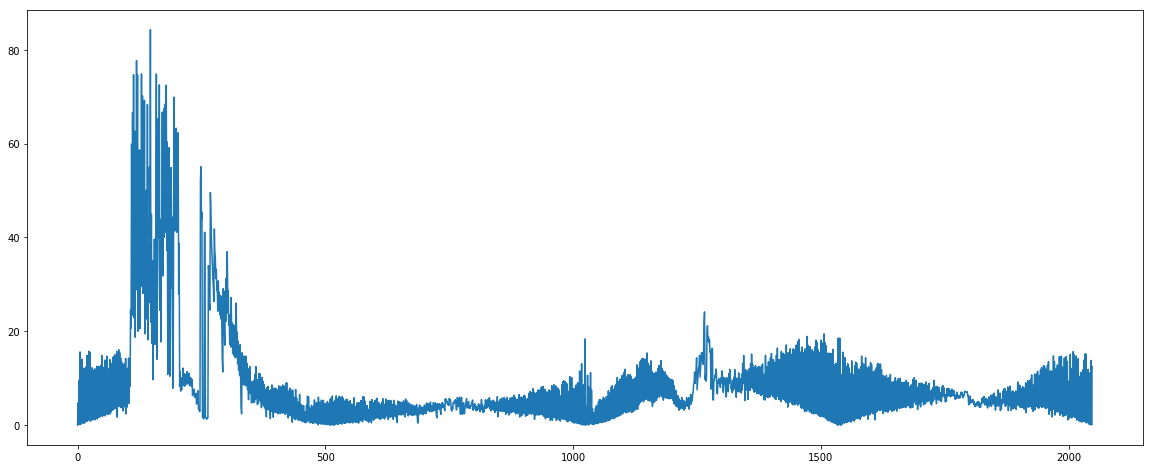

In [75]:
plt.plot(b)

In [76]:
np.mean(b)

8.514639548026347

In [11]:
def transform(data, scaler):
    old_shape = data.shape
    data = data.reshape(old_shape[0], -1)
    if scaler is not None:
        data = scaler.transform(data.astype(np.float))
    return data.reshape(old_shape)
    #return data

def transform_standardize(data, mean, std):
    old_shape = data.shape
    data = data.reshape(-1, old_shape[1]*old_shape[2])
    data = (data - mean)/std
    return data.reshape(old_shape)
    #return data

def find_mean_std(data):
    old_shape = data.shape
    data = data.reshape(-1, old_shape[1]*old_shape[2])
    mean = np.mean(data, axis=0).reshape(1, -1)
    std = np.std(data, axis=0).reshape(1, -1)
    std[std == 0] = 1
    #mean = mean.reshape(-1, old_shape[-1])
    #std = std.reshape(-1, old_shape[-1])
    return mean, std

In [12]:
scaler = None
scale_data = False
if scale_data:
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_boundary_vectors.reshape(train_boundary_vectors.shape[0], -1))

mean, std = find_mean_std(train_boundary_vectors)
train_boundary_vectors_1 = transform_standardize(train_boundary_vectors, mean, std)
val_boundary_vectors_1 = transform_standardize(val_boundary_vectors, mean, std)
test_boundary_vectors_1 = transform_standardize(test_boundary_vectors, mean, std)

In [13]:
def create_dataset(boundary_vectors_scale, timesteps):
    data_X = []
    data_Y = []
    for i in range(len(boundary_vectors_scale) - timesteps):
        data_x = boundary_vectors_scale[i:(i+timesteps)]
        data_y = boundary_vectors_scale[i + timesteps]
        data_X.append(data_x)
        data_Y.append(data_y)
    return np.asarray(data_X), np.asarray(data_Y)

In [14]:
from numpy import polyfit

In [15]:
plt.rcParams['figure.figsize'] = (20, 8)

In [16]:
n_years = len(data_1)//46

In [17]:
data_2 = data_1[:24].copy()
data_3 = data_1[24:]
for i in range(n_years):
    year = 2003 + i
    if year != 2011 and year != 2013:
        data_2 = np.vstack([data_2, data_3[i*46 : (i + 1)*46]])

data_1.shape, data_2.shape

((714, 1024, 2), (622, 1024, 2))

/usr/local/lib/python3.6/site-packages/numpy/lib/polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


Coefficients: [-0.00000000e+000  0.00000000e+000 -0.00000000e+000  0.00000000e+000
  0.00000000e+000 -0.00000000e+000  0.00000000e+000 -0.00000000e+000
 -2.89361570e-142  1.69555679e-141  3.76612581e-139  1.94433623e-137
  6.84942205e-136  1.55573599e-134 -5.72633176e-134 -3.25139840e-131
 -2.42141703e-129 -1.30230681e-127 -5.81632267e-126 -2.20017012e-124
 -6.66146173e-123 -1.17379552e-121  3.39129834e-120  5.13142801e-118
  3.60157840e-116  1.98846084e-114  9.46812603e-113  3.96920277e-111
  1.43836955e-109  4.12916783e-108  5.81514976e-107 -3.45352648e-105
 -4.10618831e-103 -2.77817483e-101 -1.51946302e-099 -7.22105765e-098
 -3.02206686e-096 -1.08615555e-094 -3.01925086e-093 -3.31715662e-092
  3.39975405e-090  3.56626094e-088  2.32190262e-086  1.23014261e-084
  5.60926458e-083  2.19576049e-081  6.91822978e-080  1.27842488e-078
 -3.59355611e-077 -5.67753787e-075 -4.01289080e-073 -2.17667592e-071
 -9.81527631e-070 -3.63583359e-068 -9.71733406e-067 -4.52825575e-066
  1.65679969e-063  1

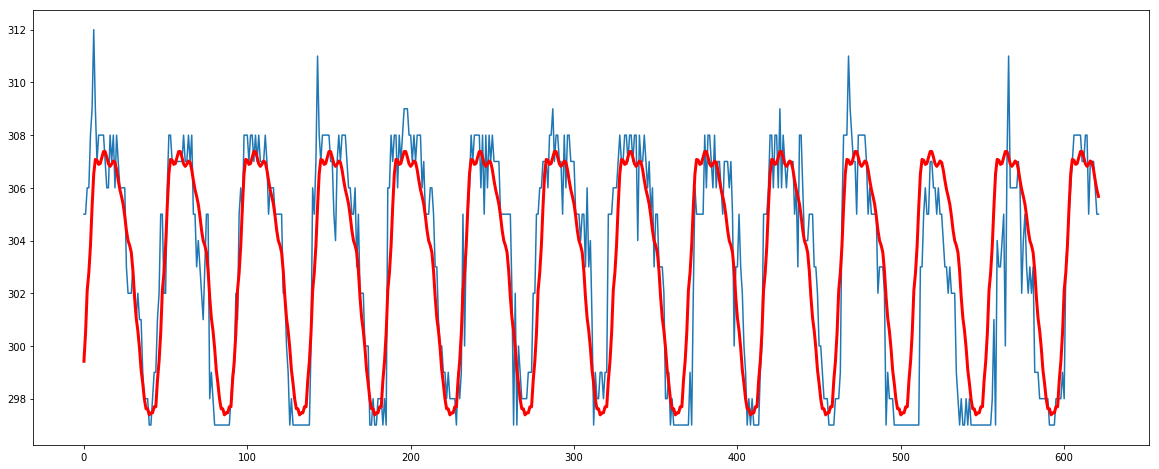

In [18]:
X = [i%46 for i in range(0, len(data_2))]
y = data_2[:, 0, 1]
degree = 100
coef1 = polyfit(X, y, degree)
print('Coefficients: %s' % coef1)
# create curve
curve1 = list()
for i in range(len(X)):
    value = coef1[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef1[d]
    curve1.append(value)
    
# plot curve over original data
plt.plot(y)
plt.plot(curve1, color='red', linewidth=3)
plt.show()

In [19]:
data_2.shape

(622, 1024, 2)

In [20]:
data = data_2.reshape(data_2.shape[0], -1)
data.shape

(622, 2048)

In [21]:
n_tests = 92
data_train = data[:-n_tests]

In [22]:
data_train.shape

(530, 2048)

In [23]:
import pandas as pd

In [24]:
data = data_2.reshape(data_2.shape[0], -1)
data.shape

(622, 2048)

In [25]:
df = pd.DataFrame(data=data)

In [26]:
df1 = df.loc[:, (df != df.iloc[0]).any()]

In [27]:
data_train = df1[:-n_tests]
data_test = df1[-n_tests:]

data_train.shape, data_test.shape

((530, 2021), (92, 2021))

In [28]:
column_index = data_test.columns.values

In [29]:
def mse(x, y):
    if isinstance(x, pd.Series) or isinstance(x, pd.DataFrame):
        x = x.values
    if isinstance(y, pd.Series) or isinstance(y, pd.DataFrame):
        y = y.values
    return np.mean((x - y)**2)

In [30]:
def save_data_pickle(data, path):
    with open(path, 'wb') as f:
        pickle.dump(data, f)

def load_data_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [31]:
import multiprocessing as mp
from multiprocessing import Process, Array, Manager

In [32]:
def split_index(n_processes, n_cores):
    rem = n_processes % n_cores
    a = n_processes - rem
    n_processes_per_core = a // n_cores
    b = np.arange(0, a, n_processes_per_core)
    res = []
    idx = 0
    for i in range(rem):
        res.append([idx, idx + n_processes_per_core + 1])
        idx += n_processes_per_core + 1
    for i in range(rem, n_cores):
        res.append([idx, idx + n_processes_per_core])
        idx += n_processes_per_core
    return res

In [33]:
res = split_index(10, 3)
res

[[0, 4], [4, 7], [7, 10]]

In [34]:
class VSARIMA:

    def __init__(self, data_train=None, data_test=None, mode='train'):
        self.data_train = data_train
        self.data_test = data_test
        self.n_data = data_train.shape[-1]
        self.log = 'log.csv'
        self.log_dir = 'sarima'
        self.train_loss = None
        self.mean_train_loss = None

        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)

        self.data_train_path = 'data_train_df.dat'
        self.data_test_path = 'data_test_df.dat'
        if self.data_train is not None:
            save_data_pickle(self.data_train, self.data_train_path)
        if self.data_test is not None:
            save_data_pickle(self.data_test, self.data_test_path)

        self.mode = mode
        if self.mode == 'inference':
            self.load_model(self.log_dir)
        else:
            self.results = self._create_empty_list(self.n_data)

    def _create_empty_list(self, n):
        res = []
        for _ in range(n):
            res.append(None)
        return res

    def load_model(self, log_dir):
        self.results = []
        for i in range(self.n_data):
            self.results.append(os.path.join(log_dir, '{}.dat'.format(i)))
        return self.results

    def train(self):
        return self._train(self.data_train, self.data_test, [0, self.n_data])

    def _train(self, data_train, data_test, idx):
        start_time = time()
        train_loss = []
        for i in range(idx[0], idx[1]):
            subprocess.call(['python3.6', 'sarima.py', self.data_train_path,
                self.data_test_path, self.log, self.log_dir, str(i), str(start_time)])
            if i % 10 == 0:
                print(i)
        end_time = time()
        print("Training time = {:0.3f}s".format(end_time - start_time))
        return self.results

    def calc_loss(self, start_idx, end_idx, data_test):
        res = []
        steps = data_test.shape[0]
        for i in range(start_idx, end_idx + 1):
            results = self.results[i]
            if self.mode == 'inference':
                _, results, _, _ = load_data_pickle(results)
            forecast = results.forecast(steps)
            loss = mse(forecast, data_test.iloc[:,i])
            res.append(loss)
        return res
    
    def inference(self, steps=1):
        res = []
        for i in range(self.n_data):
            if i % 10 == 0:
                print(i, end=' ')
            results = self.results[i]
            if self.mode == 'inference':
                _, results, _, _ = load_data_pickle(results)
            res.append(results.forecast(steps))
        return pd.concat(res, ignore_index=True, axis=1)

    def eval(self, groundtruth, metric=None):
        steps = groundtruth.shape[0]
        yhat = self.inference(steps)
        if metric is None:
            metric = mse
        return yhat, metric(groundtruth, yhat)

In [35]:
vsarima = VSARIMA(data_train, data_test, mode='inference')

In [36]:
start_time = time()
inference_vsarima = vsarima.inference(steps=n_tests)
end_time = time()
print('inference_time = {:0.3f}s'.format(end_time - start_time))

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 inference_time = 9092.374s


In [37]:
cache_data(inference_vsarima, 'sarima_inference.dat')

In [38]:
def convert(data_inference, column_index, df):
    max_index = np.max(columns_index)
    res = np.zeros((max_index + 1, data_inference.shape[0]))
    for i, col_index in enumerate(columns_index):
        res[col_index] = data_inference[i].values
    unique_value_column_index = np.setdiff1d(np.arange(max_index + 1), column_index)
    for i in unique_value_column_index:
        res[i] = np.unique(df[i].values)
    res = res.T
    return res.reshape(res.shape[0], -1, 2)

In [39]:
columns_index = data_test.columns.values

In [41]:
data_inference = convert(inference_vsarima, columns_index, df)

In [42]:
data_inference = np.round(data_inference).astype(np.uint)

In [43]:
data_inference.shape

(92, 1024, 2)

In [47]:
data_test_1 = df[-92:]
data_test_1.shape

(92, 2048)

In [48]:
data_test_1 = data_test_1.values.reshape(data_inference.shape)

In [49]:
data_test_1.shape

(92, 1024, 2)

In [51]:
print(mse(data_inference, data_test_1))

144.12247367527175


In [56]:
def mse_2(x, y):
    a = (x - y)**2
    b = np.where(a > 30, 0, 1)
    c = a*b
    return np.sum(c)/np.sum(b)

In [57]:
print(mse_2(data_inference, data_test_1))

2.3048238552199396


In [59]:
convlstm_inference = restore_data('../simple_63/convlstm_predict_boundary_vectors.dat')
convlstm_predict = convlstm_inference[-n_tests:].reshape(data_test_1.shape)
convlstm_predict.shape

(92, 1024, 2)

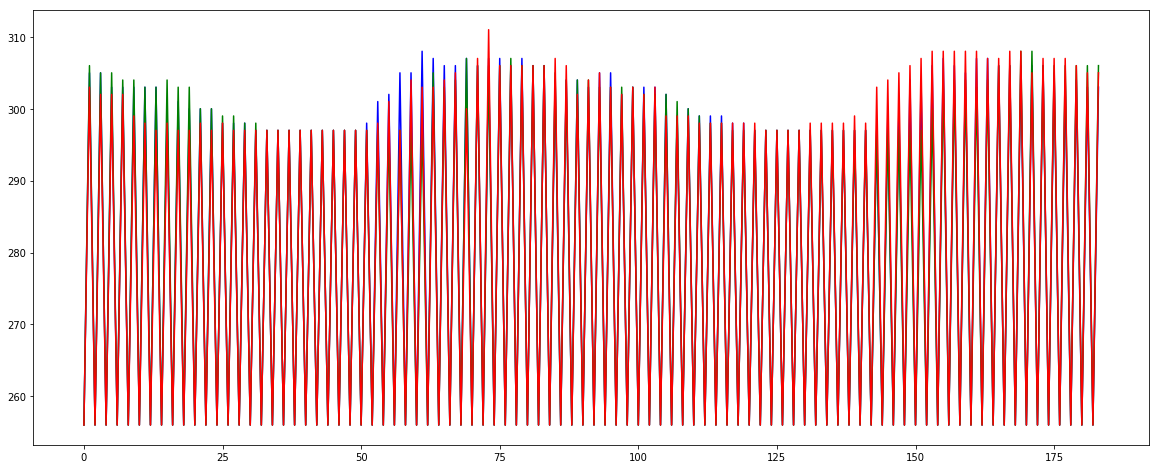

In [63]:
plt.plot(data_inference[:,0].reshape(-1, 1), color='b', label='sarima')
plt.plot(convlstm_predict[:,0].reshape(-1, 1), color='g', label='convlstm')
plt.plot(data_test_1[:,0].reshape(-1, 1), color='r', label='observed')